<a href="https://colab.research.google.com/github/wr0124/Learning_essential/blob/main/self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding and Coding the Self-Attention Mechanism of Large Language Models From Scratch
# https://magazine.sebastianraschka.com/p/understanding-and-coding-self-attention

In [2]:
sentence = 'Life is short, eat dessert first'

dc = {s:i for i,s in enumerate(sorted(sentence.replace(',', '').split()))}
print(dc)

{'Life': 0, 'dessert': 1, 'eat': 2, 'first': 3, 'is': 4, 'short': 5}


In [3]:
import torch

sentence_int = torch.tensor([dc[s] for s in sentence.replace(',', '').split()])
print(sentence_int)

tensor([0, 4, 5, 2, 1, 3])


Note that embedding sizes typically range from hundreds to thousands of dimensions. For instance, Llama 2 utilizes embedding sizes of 4,096. The reason we use 3-dimensional embeddings here is purely for illustration purposes. This allows us to examine the individual vectors without filling the entire page with numbers.

Since the sentence consists of 6 words, this will result in a 6×3-dimensional embedding:

In [4]:
vocab_size = 50_000
torch.manual_seed(123)
embed = torch.nn.Embedding(vocab_size, 3)
embedded_sentence = embed(sentence_int).detach()
print(embedded_sentence)
print(embedded_sentence.shape)

tensor([[ 0.3374, -0.1778, -0.3035],
        [ 0.1794,  1.8951,  0.4954],
        [ 0.2692, -0.0770, -1.0205],
        [-0.2196, -0.3792,  0.7671],
        [-0.5880,  0.3486,  0.6603],
        [-1.1925,  0.6984, -1.4097]])
torch.Size([6, 3])


### Defining the Weight Matrices

Here, both q(i) and k(i) are vectors of dimension dk. The projection matrices Wq and Wk have a shape of d × dk , while Wv has the shape d × dv .

(It's important to note that d represents the size of each word vector, x.)

Since we are computing the dot-product between the query and key vectors, these two vectors have to contain the same number of elements (dq = dk). In many LLMs, we use the same size for the value vectors such that dq = dk = dv. However, the number of elements in the value vector v(i), which determines the size of the resulting context vector, can be arbitrary.

So, for the following code walkthrough, we will set dq = dk = 2 and use dv = 4, initializing the projection matrices as follows:

In [5]:
torch.manual_seed(123)

d = embedded_sentence.shape[1]
print(d)
d_q, d_k, d_v = 2, 2, 4
W_query = torch.nn.Parameter(torch.rand(d, d_q))
W_key = torch.nn.Parameter(torch.rand(d, d_k))
W_value = torch.nn.Parameter(torch.rand(d, d_v))

3


Computing the Unnormalized Attention Weights

In [ ]:
x_2 = embedded_sentence[1]
print(x_2)
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2.shape)
print(key_2.shape)
print(value_2.shape)

tensor([0.1794, 1.8951, 0.4954])
torch.Size([2])
torch.Size([2])
torch.Size([4])


We can then generalize this to compute the remaining key, and value elements for all inputs as well, since we will need them in the next step when we compute the unnormalized attention weights later:

In [ ]:
import numpy as np

# Define two matrices
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])

# Perform matrix multiplication using @
C = A @ B
print(C)
D = A.dot(B)
print(D)

[[19 22]
 [43 50]]
[[19 22]
 [43 50]]


In [ ]:
keys = embedded_sentence @ W_key
values = embedded_sentence @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 4])


Now that we have all the required keys and values, we compute ωi,j as the dot product between the query and key sequences, ωi,j = q(i) k(j).

In [ ]:
omega_24 = query_2.dot(keys[4])
print(omega_24)

tensor(1.2903, grad_fn=<DotBackward0>)


Since we will need those unnormalized attention weights ω to compute the actual attention weights later, let's compute the ω values for all input tokens

In [ ]:
omega_2 = query_2 @ keys.T
print(omega_2)

tensor([-0.6004,  3.4707, -1.5023,  0.4991,  1.2903, -1.3374],
       grad_fn=<SqueezeBackward4>)


Computing the Attention Weights

In [ ]:
import torch.nn.functional as F
attention_weights_2 = F.softmax(omega_2 / d_k**0.5, dim=0)
print(attention_weights_2)

tensor([0.0386, 0.6870, 0.0204, 0.0840, 0.1470, 0.0229],
       grad_fn=<SoftmaxBackward0>)


Finally, the last step is to compute the context vector z(2), which is an attention-weighted version of our original query input x(2), including all the other input elements as its context via the attention weights:

In [ ]:
context_vector_2 = attention_weights_2 @ values

print(context_vector_2.shape)
print(context_vector_2)

torch.Size([4])
tensor([0.5313, 1.3607, 0.7891, 1.3110], grad_fn=<SqueezeBackward4>)


#Self-Attention

In [ ]:
import torch.nn as nn
class SelfAttention(nn.Module):

    def __init__(self, d_in, d_out_kq, d_out_v):
        super().__init__()
        self.d_out_kq = d_out_kq
        self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T  # unnormalized attention weights
        attn_weights = torch.softmax(
            attn_scores / self.d_out_kq**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

In [ ]:
torch.manual_seed(123)
# d_in  3-dimensional embedding such that each input word is represented by a 3-dimensional vector.
# d_out_kq  d_q is the same as d_k, the projection matrics W_q, W_k has shape of d*d_k
# d_out_v   projection matrics w_v has shape d*d_v
# reduce d_out_v from 4 to 1, because we have 4 heads
d_in, d_out_kq, d_out_v = 3, 2, 4

sa = SelfAttention(d_in, d_out_kq, d_out_v)
print(sa(embedded_sentence))

tensor([[-0.1564,  0.1028, -0.0763, -0.0764],
        [ 0.5313,  1.3607,  0.7891,  1.3110],
        [-0.3542, -0.1234, -0.2626, -0.3706],
        [ 0.0071,  0.3345,  0.0969,  0.1998],
        [ 0.1008,  0.4780,  0.2021,  0.3674],
        [-0.5296, -0.2799, -0.4107, -0.6006]], grad_fn=<MmBackward0>)


#Multi-Head Attention

   - d_in: Dimension of the input feature vector.

   - d_out_kq: Dimension for both query and key outputs.

   - d_out_v: Dimension for value outputs.

   - num_heads: Number of attention heads.

In [ ]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out_kq, d_out_v, num_heads):
        super().__init__()
        self.heads = nn.ModuleList(
            [SelfAttention(d_in, d_out_kq, d_out_v)
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

First, let's suppose we have a single Self-Attention head with output dimension 1 to keep it simple for illustration purposes:

In [ ]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 1

sa = SelfAttention(d_in, d_out_kq, d_out_v)
print(sa(embedded_sentence))

tensor([[-0.0185],
        [ 0.4003],
        [-0.1103],
        [ 0.0668],
        [ 0.1180],
        [-0.1827]], grad_fn=<MmBackward0>)


Now, let's extend this to 4 attention heads:

In [ ]:
torch.manual_seed(123)

block_size = embedded_sentence.shape[1]
mha = MultiHeadAttentionWrapper(
    d_in, d_out_kq, d_out_v, num_heads=4
)

context_vecs = mha(embedded_sentence)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[-0.0185,  0.0170,  0.1999, -0.0860],
        [ 0.4003,  1.7137,  1.3981,  1.0497],
        [-0.1103, -0.1609,  0.0079, -0.2416],
        [ 0.0668,  0.3534,  0.2322,  0.1008],
        [ 0.1180,  0.6949,  0.3157,  0.2807],
        [-0.1827, -0.2060, -0.2393, -0.3167]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([6, 4])


hy do we even need multiple attention heads if we can regulate the output embedding size in the SelfAttention class itself?

For instance, each attention head in multi-head attention can potentially learn to focus on different parts of the input sequence, capturing various aspects or relationships within the data. This diversity in representation is key to the success of multi-head attention.

Multi-head attention can also be more efficient, especially in terms of parallel computation. Each head can be processed independently, making it well-suited for modern hardware accelerators like GPUs or TPUs that excel at parallel processing.

In short, the use of multiple attention heads is not just about increasing the model's capacity but about enhancing its ability to learn a diverse set of features and relationships within the data.

#Cross-Attention

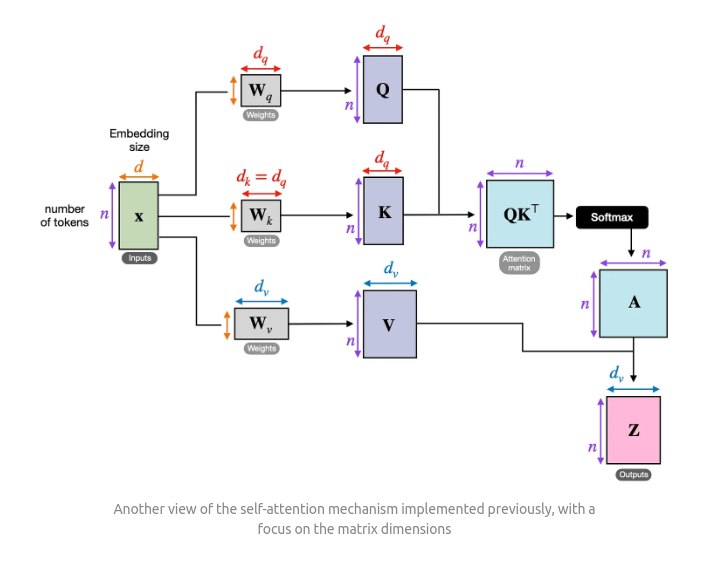

What is cross-attention, and how does it differ from self-attention?

 In cross-attention, we mix or combine two different input sequences. In the case of the original transformer architecture above, that's the sequence returned by the encoder module on the left and the input sequence being processed by the decoder part on the right.
 Note that in cross-attention, the two input sequences x_1 and x_2 can have different numbers of elements. However, their embedding dimensions must match.

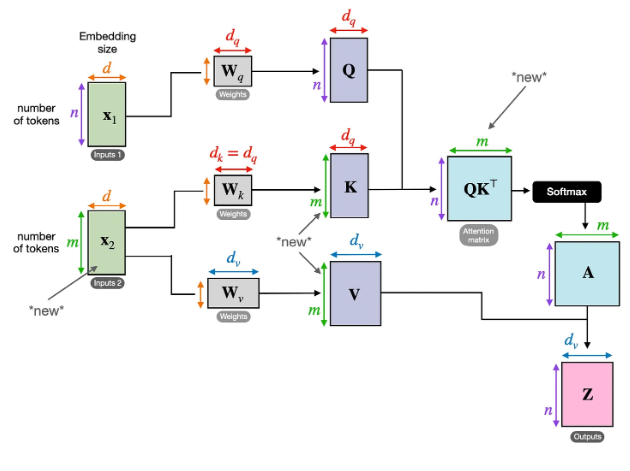

(Note that the queries usually come from the decoder, and the keys and values typically come from the encoder.)

In [ ]:
class CrossAttention(nn.Module):

    def __init__(self, d_in, d_out_kq, d_out_v):
        super().__init__()
        self.d_out_kq = d_out_kq
        self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))

    def forward(self, x_1, x_2):           # x_2 is new
        queries_1 = x_1 @ self.W_query

        keys_2 = x_2 @ self.W_key          # new
        values_2 = x_2 @ self.W_value      # new

        attn_scores = queries_1 @ keys_2.T # new
        attn_weights = torch.softmax(
            attn_scores / self.d_out_kq**0.5, dim=-1)

        context_vec = attn_weights @ values_2
        return context_vec

The differences between the CrossAttention class and the previous SelfAttention class are as follows:

- The forward method takes two distinct inputs, x_1 and x_2. The queries are derived from x_1, while the keys and values are derived from x_2. This means that the attention mechanism is evaluating the interaction between two different inputs.

- The attention scores are calculated by taking the dot product of the queries (from x_1) and keys (from x_2).

- Similar to SelfAttention, each context vector is a weighted sum of the values. However, in CrossAttention, these values are derived from the second input (x_2), and the weights are based on the interaction between x_1 and x_2.

In [ ]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 4

crossattn = CrossAttention(d_in, d_out_kq, d_out_v)

first_input = embedded_sentence
second_input = torch.rand(8, d_in)

print("First input shape:", first_input.shape)
print("Second input shape:", second_input.shape)

First input shape: torch.Size([6, 3])
Second input shape: torch.Size([8, 3])


In [ ]:
context_vectors = crossattn(first_input, second_input)

print(context_vectors)
print("Output shape:", context_vectors.shape)

tensor([[0.4231, 0.8665, 0.6503, 1.0042],
        [0.4874, 0.9718, 0.7359, 1.1353],
        [0.4054, 0.8359, 0.6258, 0.9667],
        [0.4357, 0.8886, 0.6678, 1.0311],
        [0.4429, 0.9006, 0.6775, 1.0460],
        [0.3860, 0.8021, 0.5985, 0.9250]], grad_fn=<MmBackward0>)
Output shape: torch.Size([6, 4])


#Causal Self-Attention

 This causal self-attention mechanism is also often referred to as “masked self-attention”.  In the original transformer architecture, it corresponds to the “masked multi-head attention” module — for simplicity, we will look at a single attention head in this section, but the same concept generalizes to multiple heads.

 for each token processed, we mask out the future tokens, which come after the current token in the input text.
 To illustrate and implement causal self-attention, let's work with the unweighted attention scores and attention weights from the previous section. First, we quickly recap the computation of the attention scores from the previous Self-Attention section:

In [ ]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 4

W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
W_value = nn.Parameter(torch.rand(d_in, d_out_v))

x = embedded_sentence

keys = x @ W_key
queries = x @ W_query
values = x @ W_value

# attn_scores are the "omegas",
# the unnormalized attention weights
attn_scores = queries @ keys.T

print(attn_scores)
print(attn_scores.shape)

tensor([[ 0.0613, -0.3491,  0.1443, -0.0437, -0.1303,  0.1076],
        [-0.6004,  3.4707, -1.5023,  0.4991,  1.2903, -1.3374],
        [ 0.2432, -1.3934,  0.5869, -0.1851, -0.5191,  0.4730],
        [-0.0794,  0.4487, -0.1807,  0.0518,  0.1677, -0.1197],
        [-0.1510,  0.8626, -0.3597,  0.1112,  0.3216, -0.2787],
        [ 0.4344, -2.5037,  1.0740, -0.3509, -0.9315,  0.9265]],
       grad_fn=<MmBackward0>)
torch.Size([6, 6])


Similar to the Self-Attention section before, the output above is a 6×6 tensor containing these pairwise unnormalized attention weights (also called attention scores) for the 6 input tokens.

Previously, we then computed the scaled dot-product attention via the softmax function as follows:

In [ ]:
attn_weights = torch.softmax(attn_scores / d_out_kq**0.5, dim=1)
print(attn_weights)

tensor([[0.1772, 0.1326, 0.1879, 0.1645, 0.1547, 0.1831],
        [0.0386, 0.6870, 0.0204, 0.0840, 0.1470, 0.0229],
        [0.1965, 0.0618, 0.2506, 0.1452, 0.1146, 0.2312],
        [0.1505, 0.2187, 0.1401, 0.1651, 0.1793, 0.1463],
        [0.1347, 0.2758, 0.1162, 0.1621, 0.1881, 0.1231],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<SoftmaxBackward0>)


The 6×6 output above represents the attention weights, which we also computed in the Self-Attention section before.

The simplest way to achieve this setup above is to mask out all future tokens by applying a mask to the attention weight matrix above the diagonal, as illustrated in the figure below. This way, “future” words will not be included when creating the context vectors, which are created as a attention-weighted sum over the inputs.

In [ ]:
block_size = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(block_size, block_size))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [ ]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1772, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0386, 0.6870, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1965, 0.0618, 0.2506, 0.0000, 0.0000, 0.0000],
        [0.1505, 0.2187, 0.1401, 0.1651, 0.0000, 0.0000],
        [0.1347, 0.2758, 0.1162, 0.1621, 0.1881, 0.0000],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<MulBackward0>)


In [ ]:
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0532, 0.9468, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3862, 0.1214, 0.4924, 0.0000, 0.0000, 0.0000],
        [0.2232, 0.3242, 0.2078, 0.2449, 0.0000, 0.0000],
        [0.1536, 0.3145, 0.1325, 0.1849, 0.2145, 0.0000],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<DivBackward0>)


More efficient masking without renormalization

In [ ]:
mask = torch.triu(torch.ones(block_size, block_size), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[ 0.0613,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.6004,  3.4707,    -inf,    -inf,    -inf,    -inf],
        [ 0.2432, -1.3934,  0.5869,    -inf,    -inf,    -inf],
        [-0.0794,  0.4487, -0.1807,  0.0518,    -inf,    -inf],
        [-0.1510,  0.8626, -0.3597,  0.1112,  0.3216,    -inf],
        [ 0.4344, -2.5037,  1.0740, -0.3509, -0.9315,  0.9265]],
       grad_fn=<MaskedFillBackward0>)


In [ ]:
attn_weights = torch.softmax(masked / d_out_kq**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0532, 0.9468, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3862, 0.1214, 0.4924, 0.0000, 0.0000, 0.0000],
        [0.2232, 0.3242, 0.2078, 0.2449, 0.0000, 0.0000],
        [0.1536, 0.3145, 0.1325, 0.1849, 0.2145, 0.0000],
        [0.1973, 0.0247, 0.3102, 0.1132, 0.0751, 0.2794]],
       grad_fn=<SoftmaxBackward0>)
